# Preprocessing

In [1]:
import pysewer
import matplotlib.pyplot as plt
import networkx as nx


/Users/despot/miniconda3/envs/pysewer/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
###### Create SewerNetwork Object from input Data
dem_file = "example_data/1_DEM/dem_10m1.tif"
#dem_file = False
buildings_file = "example_data/2_Buildings/buildings_projected.shp"
roads_file = "example_data/3_Roads/roads_projected.shp"
pipe_diameters = [0.2,0.3,0.4,0.5,0.8,1,2]
pressurized_diam = 0.2
type(buildings_file)

str

In [3]:
test_model_domain = pysewer.ModelDomain(dem=dem_file,buildings=buildings_file,roads=roads_file,clustering="sequ")

/Users/despot/miniconda3/envs/pysewer/lib/python3.10/site-packages/shapely/linear.py:208: RuntimeWarning: invalid value encountered in shortest_line
  return lib.shortest_line(a, b, **kwargs)
/Users/despot/miniconda3/envs/pysewer/lib/python3.10/site-packages/shapely/linear.py:208: RuntimeWarning: invalid value encountered in shortest_line
  return lib.shortest_line(a, b, **kwargs)
/Users/despot/miniconda3/envs/pysewer/lib/python3.10/site-packages/shapely/linear.py:208: RuntimeWarning: invalid value encountered in shortest_line
  return lib.shortest_line(a, b, **kwargs)
/Users/despot/miniconda3/envs/pysewer/lib/python3.10/site-packages/shapely/linear.py:208: RuntimeWarning: invalid value encountered in shortest_line
  return lib.shortest_line(a, b, **kwargs)
/Users/despot/miniconda3/envs/pysewer/lib/python3.10/site-packages/shapely/linear.py:208: RuntimeWarning: invalid value encountered in shortest_line
  return lib.shortest_line(a, b, **kwargs)
/Users/despot/miniconda3/envs/pysewer/li

In [4]:
test_model_domain.set_sink_lowest()
test_model_domain.add_sink((690500,2557000))

/Users/despot/miniconda3/envs/pysewer/lib/python3.10/site-packages/earthpy/spatial.py:556: RuntimeWarning: invalid value encountered in cast
  return (bytedata.clip(low, high) + 0.5).astype("uint8")


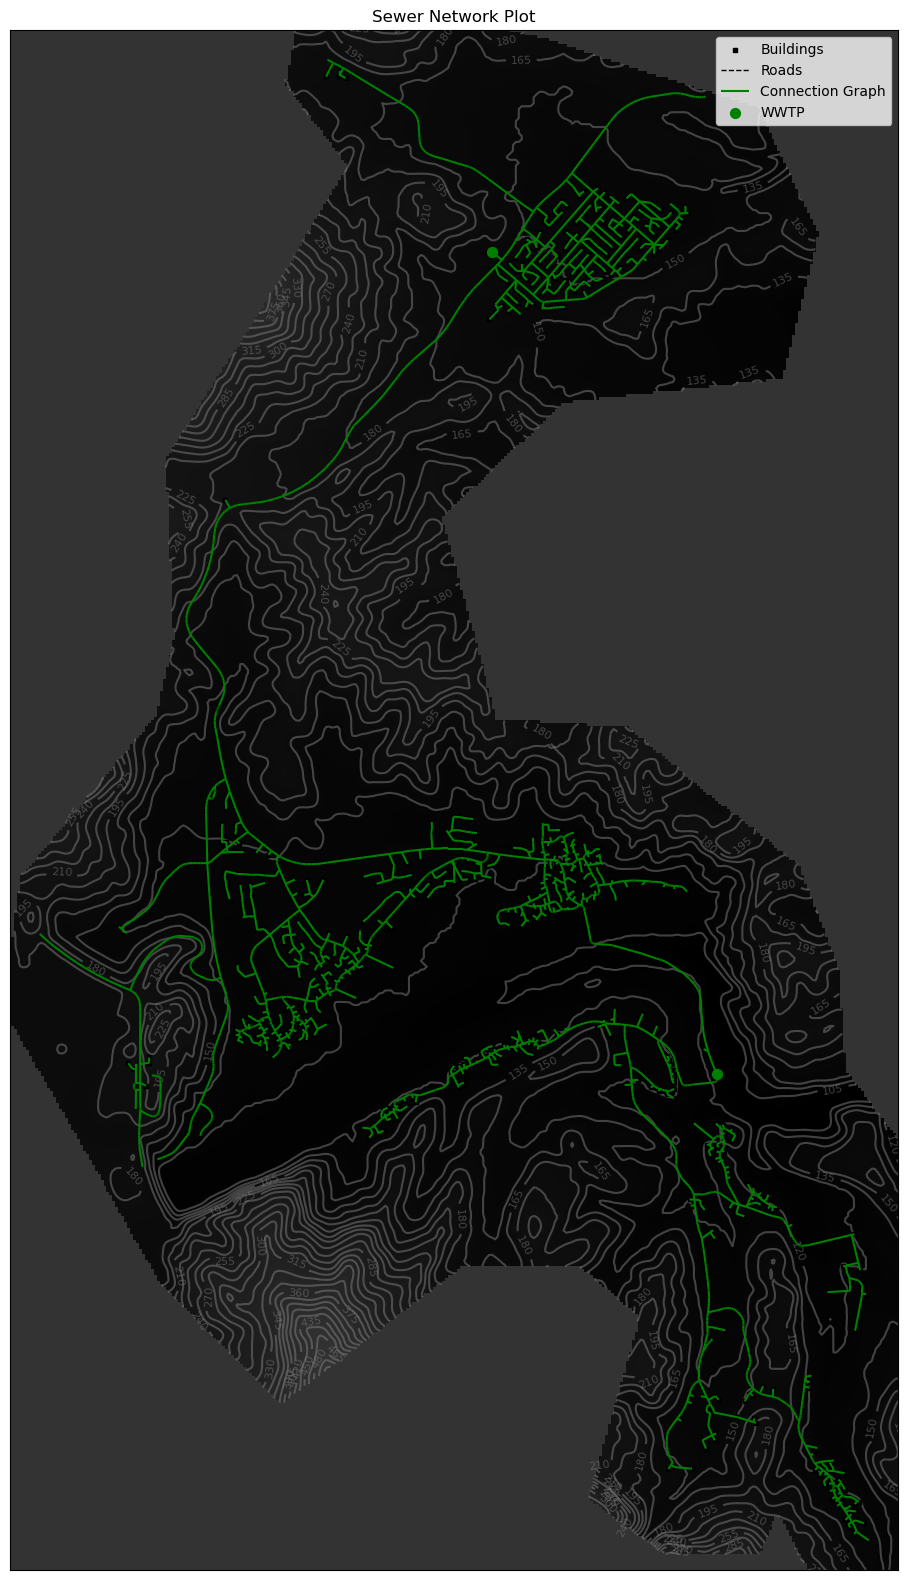

In [5]:
fig,ax = pysewer.plot_model_domain(test_model_domain,plot_connection_graph=True,hillshade=True)


In [6]:
test_model_domain.buildings.get_gdf().head()
test_model_domain.roads.get_gdf().head()

,OBJECTID,SUBTYPELBL,ROADNAMEA,ROADNAMEE,ROADNO,SHAPE_Leng,Shape_Le_1,geometry
0,8696,WAY,شارع الظاهر,al Dhahir Street,0.0,292.317700,292.272612,"LINESTRING (691331.435 2553788.287, 691357.594..."
1,9469,WAY,NaN,NaN,0.0,64.172012,64.172002,"LINESTRING (691395.982 2553820.064, 691396.500..."
2,9470,WAY,NaN,NaN,0.0,90.341907,90.341979,"LINESTRING (690606.625 2554799.500, 690612.375..."
3,9471,WAY,NaN,NaN,0.0,220.794595,220.790365,"LINESTRING (689539.873 2554939.387, 689538.108..."
4,9477,WAY,شارع السيح,al Saih Street,0.0,315.380259,315.380207,"LINESTRING (689794.875 2554488.750, 689798.250..."


In [7]:
connection_graph = test_model_domain.generate_connection_graph()

3374
1359
Simplified graph: 3374 to 1334 nodes, 3912 to 1871 edges


In [8]:
test_model_domain.get_sinks()

[(691258.1220546402, 2554226.804832181), (690500.0, 2557000.0)]

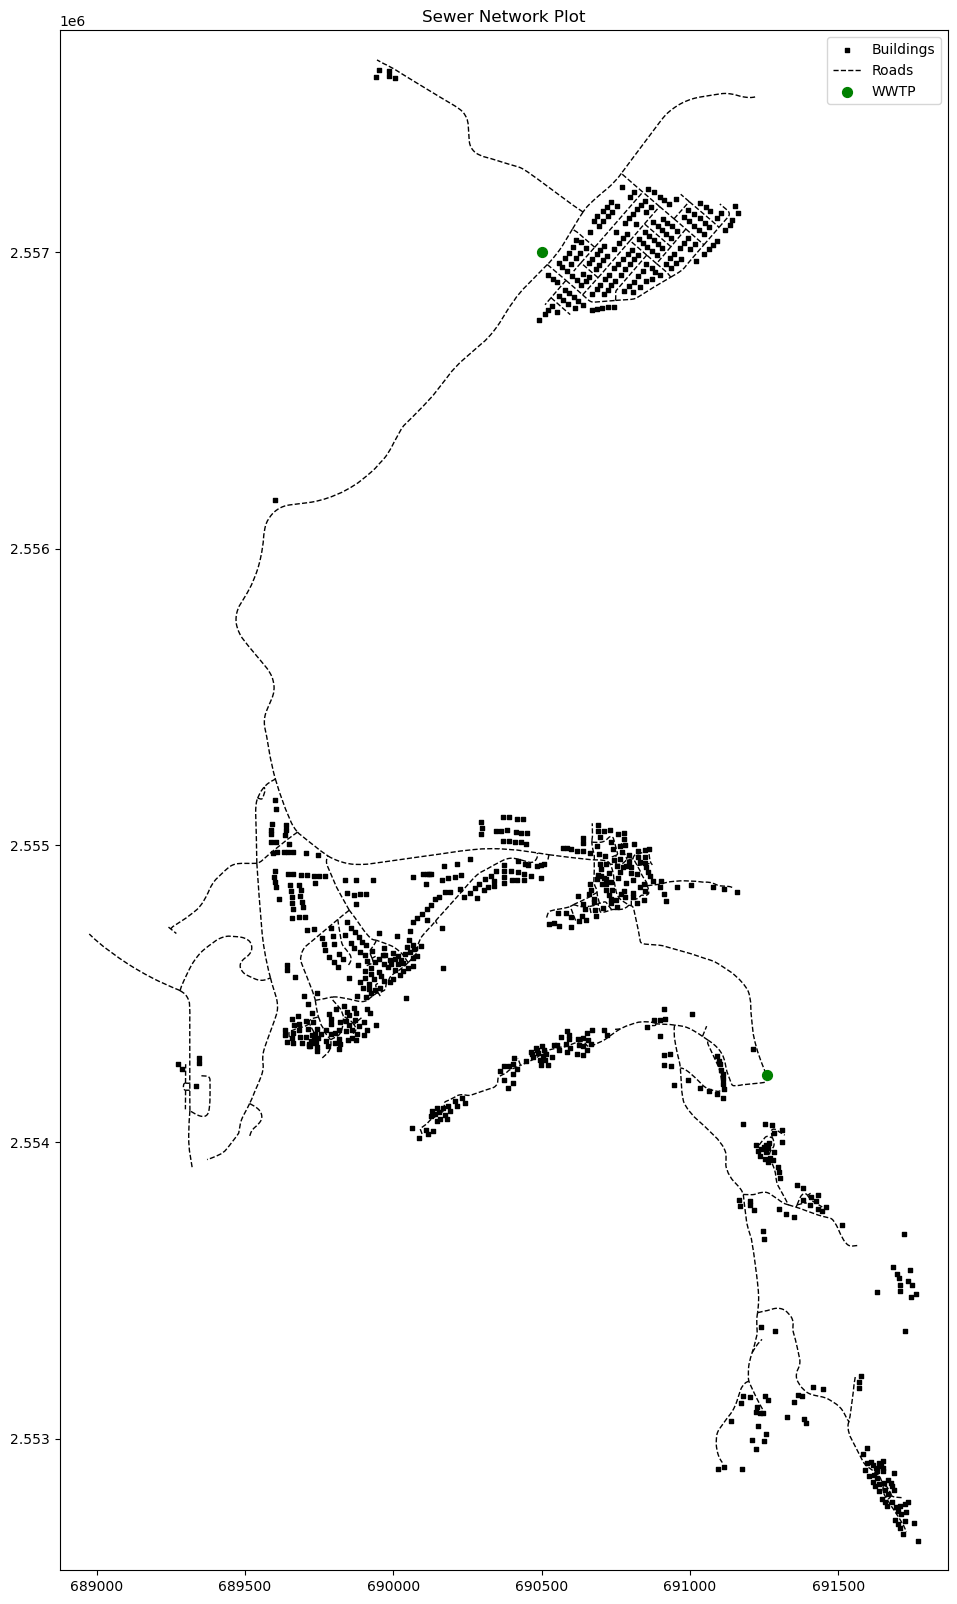

In [9]:
fig,ax = pysewer.plot_model_domain(test_model_domain,plot_sink=True)


# Routing Solver

For the network routing, an rhsp tree growing algorithm was implemented.

In [10]:
layout = pysewer.rsph_tree(connection_graph,test_model_domain.get_sinks(),"building") 

No pumping station in the sewer graph
Plotting sewer graph without pumping station


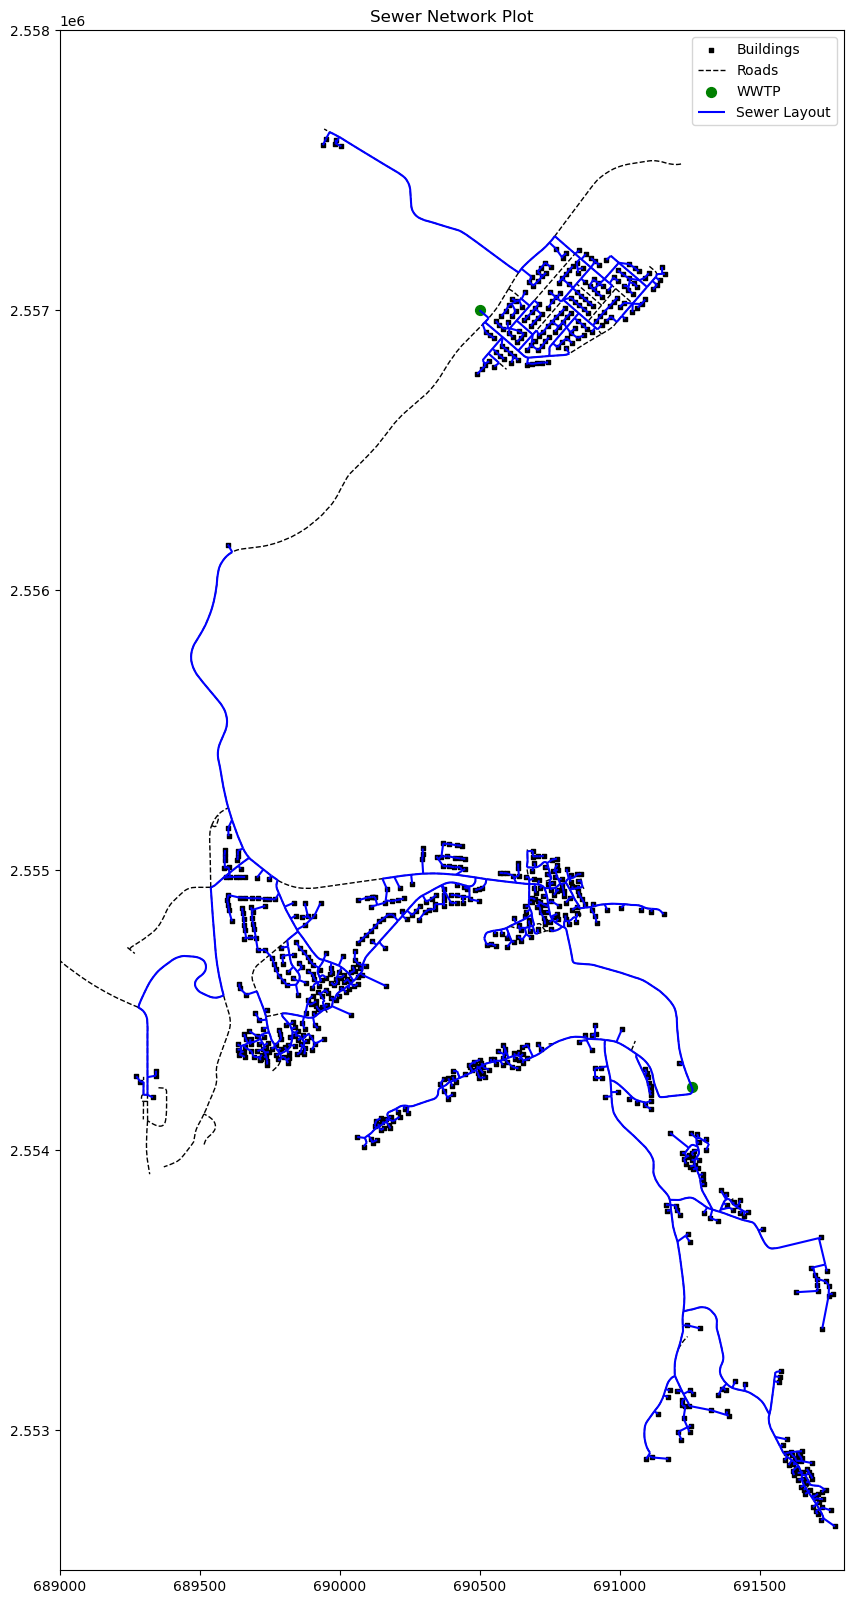

In [11]:
fig,ax = pysewer.plot_model_domain(test_model_domain, plot_sewer=True,sewer_graph = layout)
ax.set_xlim(689000, 691800)
ax.set_ylim(2552500, 2558000)
plt.show()

# Pump Optimization


0


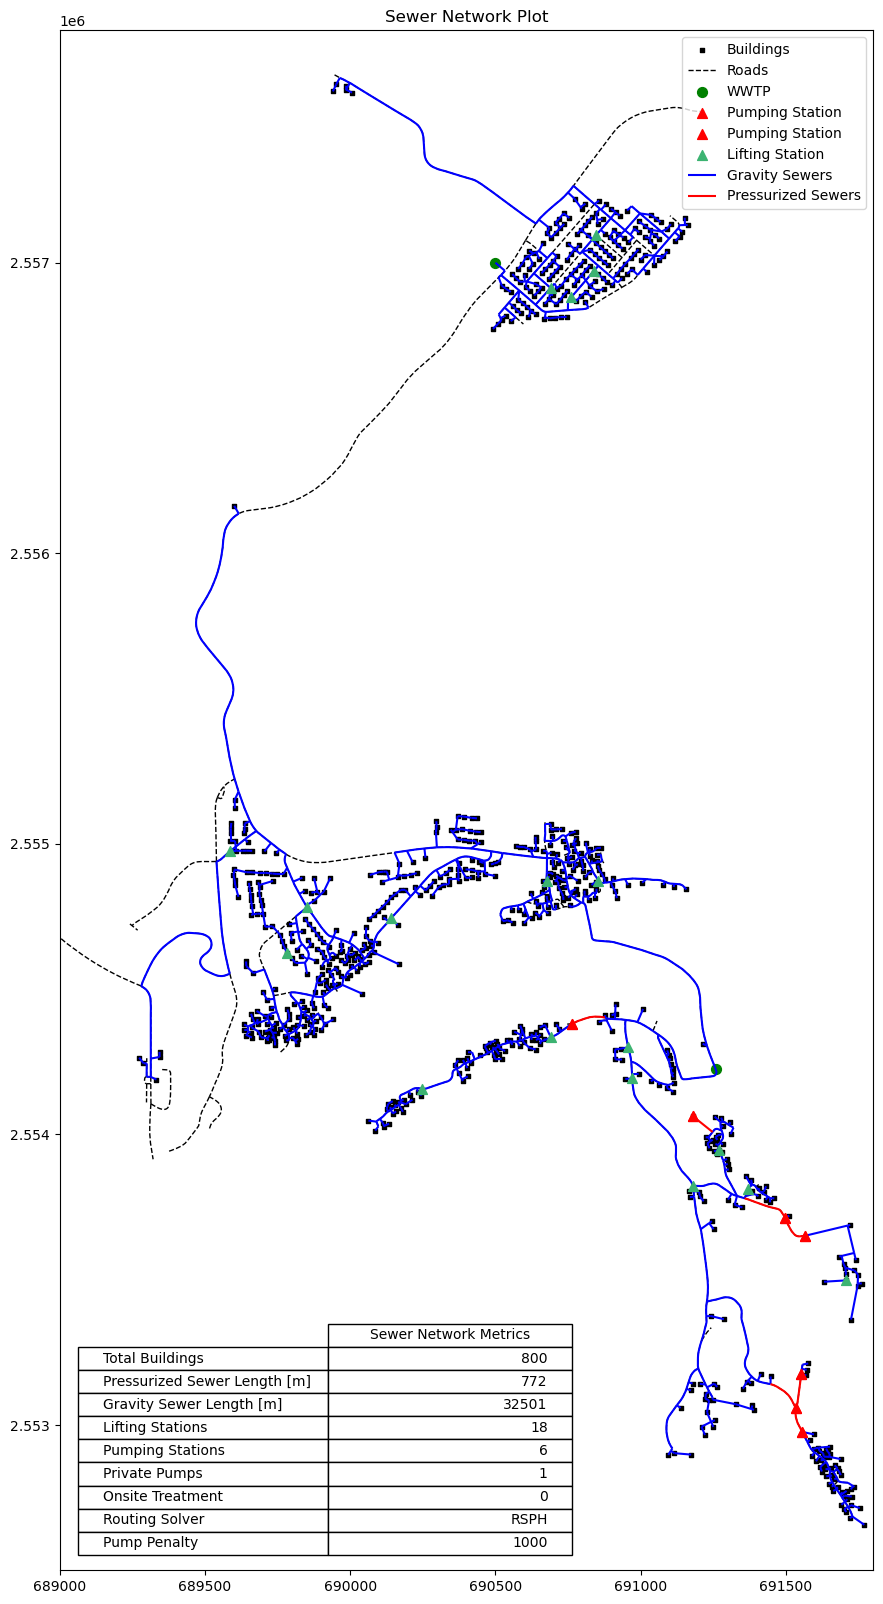

In [12]:
G = pysewer.estimate_peakflow(layout,inhabitants_dwelling=6,daily_wastewater_person=0.250)
G = pysewer.calculate_hydraulic_parameters(layout,sinks=test_model_domain.get_sinks(),diameters = pipe_diameters,pressurized_diameter=pressurized_diam,include_private_sewer=True,roughness = 0.012)
info = pysewer.get_sewer_info(G)
info["Routing Solver"] = "RSPH"
info["Pump Penalty"] = test_model_domain.pump_penalty
fig,ax = pysewer.plot_model_domain(test_model_domain, plot_sewer=True,sewer_graph = G, info_table=info)
ax.set_xlim(689000, 691800)
ax.set_ylim(2552500, 2557800)
   
ax.set_title("Sewer Network Plot")
plt.legend(loc="upper right")
plt.show()

/Users/despot/miniconda3/envs/pysewer/lib/python3.10/site-packages/geopandas/plotting.py:732: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(values.dtype):


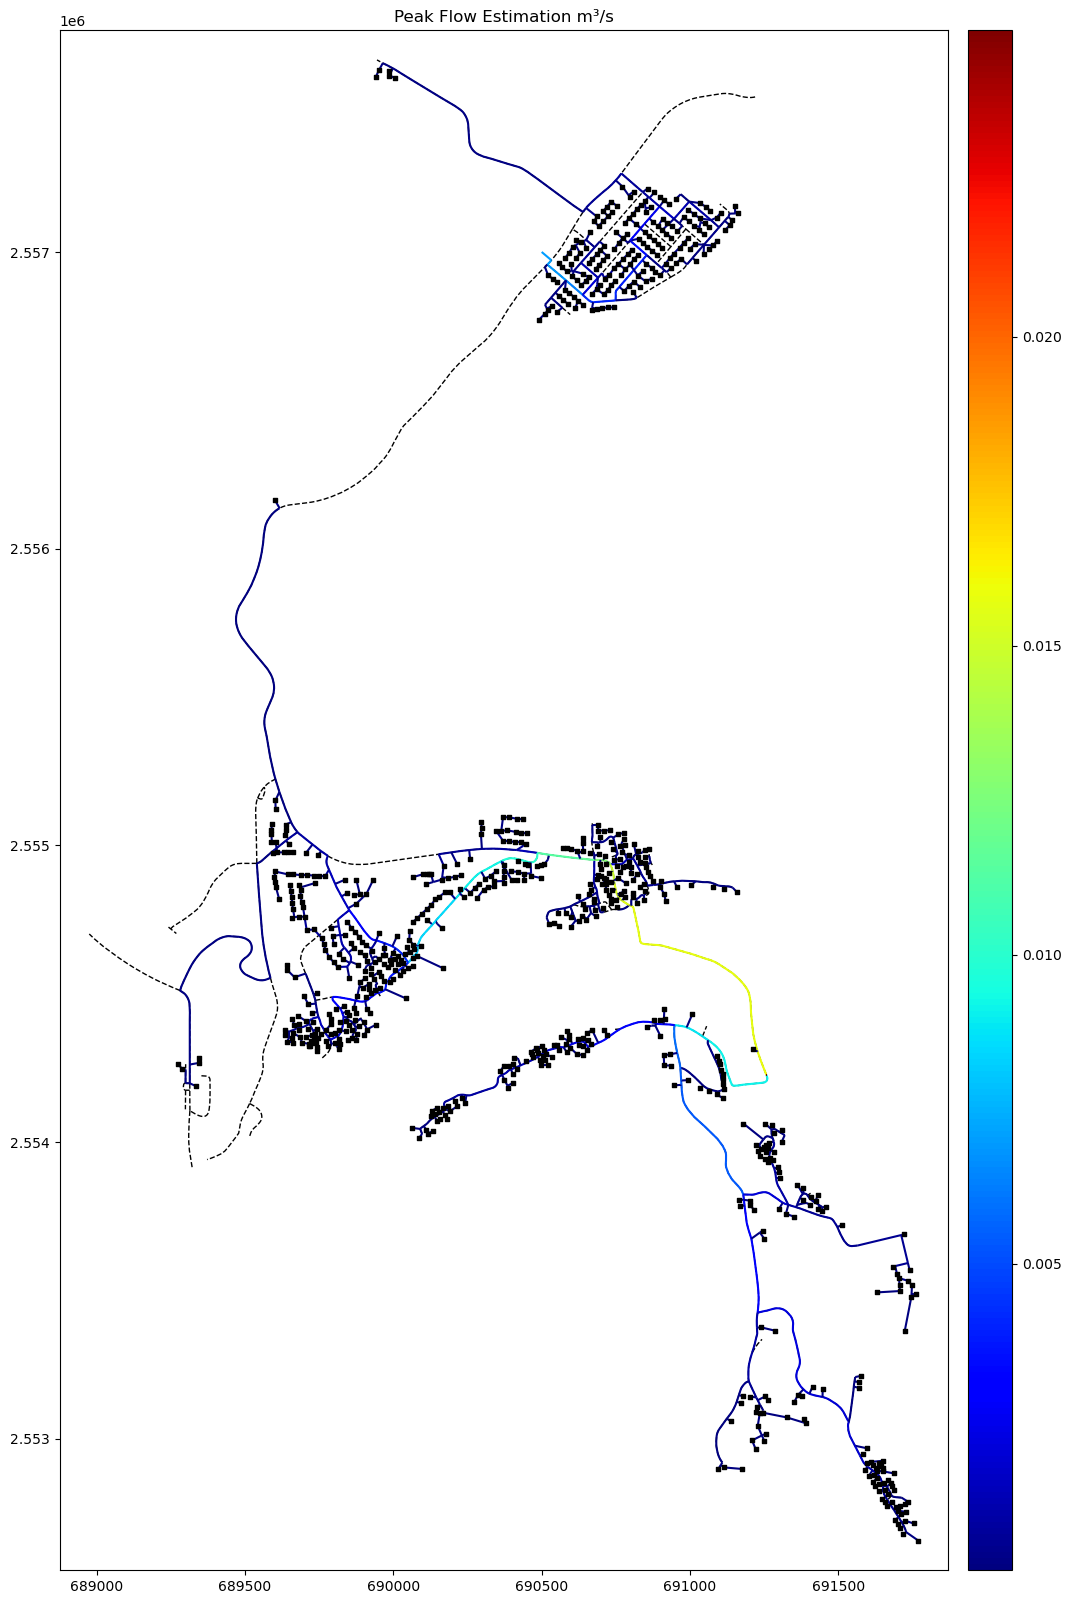

In [13]:
pysewer.plot_sewer_attributes(test_model_domain,G,attribute="peak_flow",title="Peak Flow Estimation m³/s")
plt.show()

/Users/despot/miniconda3/envs/pysewer/lib/python3.10/site-packages/geopandas/plotting.py:732: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(values.dtype):


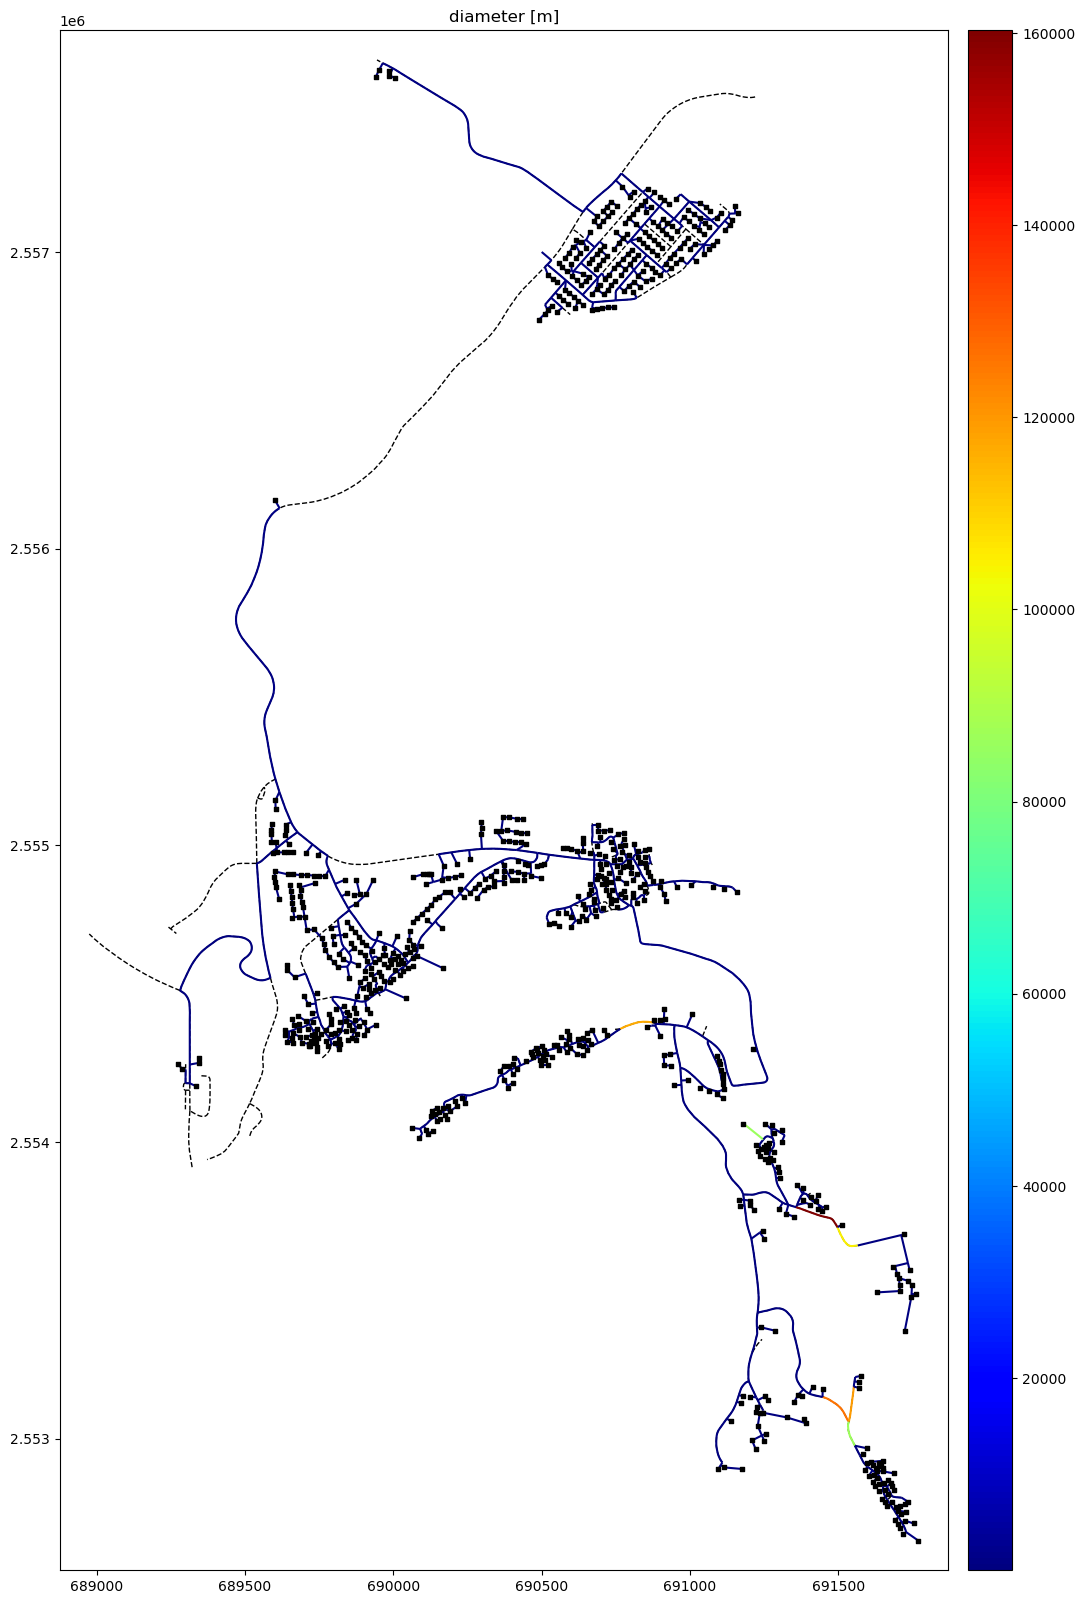

In [14]:
pysewer.plot_sewer_attributes(test_model_domain,G,attribute="weight",title="diameter [m]")
plt.show()

In [15]:
pysewer.get_edge_gdf(G,detailed=True).to_file("sewer.gpkg",driver="GPKG")

ValueError: Invalid field type <class 'list'>

In [ ]:
pysewer.get_edge_gdf(G,detailed=True)